# Сентимент для твиттера

[Данные](https://docs.google.com/file/d/0B04GJPshIjmPRnZManQwWEdTZjg/edit) [sentiment140](http://help.sentiment140.com/for-students) это англоязычный твиттер.

Он уже поделен на train/test. Train часть была размечена автоматически -- по наличию определенных эмоджи в тексте.

Тест часть была размечена людьми. Таким образом задача состоит в том, чтобы обучиться на шумных данных и сделать хорошие предсказания на тестовой выборке. И, конечно же, нужно превзойти бейзлайн решение.

Запустите следующую ячейку, если работаете в google colab. Это поможет быстро загрузить данные в текущий runtime.

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=0B04GJPshIjmPRnZManQwWEdTZjg' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=0B04GJPshIjmPRnZManQwWEdTZjg" -O dataset.zip && rm -rf /tmp/cookies.txt

Для google colab: распаковка данных внутри runtime.

In [2]:
!unzip dataset.zip

Archive:  dataset.zip
  inflating: testdata.manual.2009.06.14.csv  
  inflating: training.1600000.processed.noemoticon.csv  


Загрузка предобученных эмбеддингов.

In [0]:
!wget http://nlp.stanford.edu/data/wordvecs/glove.twitter.27B.zip

Монтирование диска

In [0]:
MOUNT_PATH="/content/drive/My\ Drive/Colab\ Notebooks/"
PY_MOUNT_PATH="/content/drive/My Drive/Colab Notebooks/"

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
! cp $MOUNT_PATH/glove.twitter.27B.zip ./

In [0]:
!unzip glove.twitter.27B.zip

Archive:  glove.twitter.27B.zip
  inflating: glove.twitter.27B.100d.txt  
  inflating: glove.twitter.27B.200d.txt  
  inflating: glove.twitter.27B.25d.txt  
  inflating: glove.twitter.27B.50d.txt  


In [5]:
import pandas as pd
import numpy as np
import re
import os

np.random.seed(101)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
train = pd.read_csv("./training.1600000.processed.noemoticon.csv", header=None, encoding='latin-1', sep=',')
train.columns = ['sentiment', 'id', 'time', 'flag', 'username', 'text']
train = train.iloc[np.random.permutation(len(train))][:100000]
train.head()

sentiment          id                          time      flag  \
250977          0  1983354434  Sun May 31 12:59:58 PDT 2009  NO_QUERY   
150064          0  1883616871  Fri May 22 08:50:14 PDT 2009  NO_QUERY   
710275          0  2257860040  Sat Jun 20 15:00:38 PDT 2009  NO_QUERY   
367641          0  2049251254  Fri Jun 05 16:33:26 PDT 2009  NO_QUERY   
575674          0  2211153017  Wed Jun 17 12:30:03 PDT 2009  NO_QUERY   

              username                                               text  
250977         Yushimi  @Kardboard yea  ugh. I don't wanna move either...  
150064        philwade  Guess there's a first time for everything, my ...  
710275  JBnVFCLover786  My cousin is going to America and it's NOT FAI...  
367641     ChelseyHart  @mitchelmusso Ahh this is my first comment to ...  
575674         GGirl33  taking care of my good friend jessica she is s...

In [0]:
train.sentiment.unique()

array([0, 4])

In [7]:
test = pd.read_csv("./testdata.manual.2009.06.14.csv", encoding='latin-1', header=None)
test.columns = ['sentiment', 'id', 'time', 'flag', 'username', 'text']
test = test.drop(test[test.sentiment == 2].index)
test.head()

sentiment  id                          time     flag  username  \
0          4   3  Mon May 11 03:17:40 UTC 2009  kindle2    tpryan   
1          4   4  Mon May 11 03:18:03 UTC 2009  kindle2    vcu451   
2          4   5  Mon May 11 03:18:54 UTC 2009  kindle2    chadfu   
3          4   6  Mon May 11 03:19:04 UTC 2009  kindle2     SIX15   
4          4   7  Mon May 11 03:21:41 UTC 2009  kindle2  yamarama   

                                                text  
0  @stellargirl I loooooooovvvvvveee my Kindle2. ...  
1  Reading my kindle2...  Love it... Lee childs i...  
2  Ok, first assesment of the #kindle2 ...it fuck...  
3  @kenburbary You'll love your Kindle2. I've had...  
4  @mikefish  Fair enough. But i have the Kindle2...

In [8]:
test.sentiment.unique()

array([4, 0])

Предобработка твиттов очень важна.

In [9]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

def clean_tweet(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r'[_"\-;%()|.,+&=*%]', '', tweet)
    tweet = re.sub(r'\.', ' . ', tweet)
    tweet = re.sub(r'\!', ' !', tweet)
    tweet = re.sub(r'\?', ' ?', tweet)
    tweet = re.sub(r'\,', ' ,', tweet)
    tweet = re.sub(r':', ' : ', tweet)
    tweet = re.sub(r'#', ' # ', tweet)
    #tweet = re.sub(r'@', ' @ ', tweet)
    tweet = re.sub(r'd .c .', 'd.c.', tweet)
    tweet = re.sub(r'u .s .', 'd.c.', tweet)
    tweet = re.sub(r' amp ', ' and ', tweet)
    tweet = re.sub(r'pm', ' pm ', tweet)
    tweet = re.sub(r'news', ' news ', tweet)
    tweet = re.sub(r' . . . ', ' ', tweet)
    tweet = re.sub(r' .  .  . ', ' ', tweet)
    tweet = re.sub(r' ! ! ', ' ! ', tweet)
    tweet = re.sub(r'&amp', 'and', tweet)
    return tweet

def preprocess(text, remove_stopwords=True):
    text = clean_tweet(text)
    # Convert words to lower case and split them
    text = text.lower().split()

    # Optionally, remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        
    msg = " ".join(text)
    
    for t in text:
        if t.startswith('http'):
            msg = msg.replace(t, 'URL')
        if t.startswith('@'):
            msg = msg.replace(t, 'username')
    
    text = msg
    
    # Clean the text
    text = re.sub(r"[^a-z]", " ", text)
    text = re.sub(r"    ", " ", text) # Remove any extra spaces
    text = re.sub(r"   ", " ", text) # Remove any extra spaces
    text = re.sub(r"  ", " ", text)
    
    # Return a list of words
    return(text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
# Example of preprocessor work
print('**BEFORE PREPROC:**', train['text'].values[0])
print('-'*4)
print('**AFTER PREPROC:** ', preprocess(train['text'].values[0]))

**BEFORE PREPROC:** @Kardboard yea  ugh. I don't wanna move either because all my textbooks and noted are all out on the table. Sigh.
----
**AFTER PREPROC:**  username yea ugh wanna move either textbooks noted table sigh


In [11]:
train = train[['text','sentiment']]
train['text'] = list(map(preprocess, train['text']))
train[:4]

text  sentiment
250977  username yea ugh wanna move either textbooks n...          0
150064  guess there s first time everything cars broke...          0
710275  cousin going america fair know wayyy pppl does...          0
367641  username ahh first comment youu love xxxand pl...          0

In [12]:
test['text'] = list(map(preprocess, test['text']))
test[:4]

sentiment  id                          time     flag username  \
0          4   3  Mon May 11 03:17:40 UTC 2009  kindle2   tpryan   
1          4   4  Mon May 11 03:18:03 UTC 2009  kindle2   vcu451   
2          4   5  Mon May 11 03:18:54 UTC 2009  kindle2   chadfu   
3          4   6  Mon May 11 03:19:04 UTC 2009  kindle2    SIX15   

                                                text  
0  username loooooooovvvvvveee kindle dx cool fan...  
1           reading kindle love lee childs good read  
2           ok first assesment kindle fucking rocks   
3  username love kindle i ve mine months never lo...

In [0]:
# Поменяем метки классов на более естественные:

# 0:negative, 4:positive
translate_labels = {0:0, 4:1} # 0:0 -- просто для наглядности:)
train.sentiment = [translate_labels[t] for t in train.sentiment]
test.sentiment = [translate_labels[t] for t in test.sentiment]

In [0]:
train.to_csv(os.path.join(PY_MOUNT_PATH,"preprocessed_train.csv"), index=False)
test.to_csv(os.path.join(PY_MOUNT_PATH,"preprocessed_test.csv"), index=False)

In [0]:
train=pd.read_csv(os.path.join(PY_MOUNT_PATH,"preprocessed_train.csv")).dropna()
test=pd.read_csv(os.path.join(PY_MOUNT_PATH,"preprocessed_test.csv")).dropna()

# Бейзлайн

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer 
transformer = TfidfVectorizer(min_df=40, max_features=6000)
X_train = transformer.fit_transform(train.text)

In [0]:
X_test = transformer.transform(test.text)

In [0]:
y_train = train.sentiment
y_test = test.sentiment

In [17]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [0]:
# check on test part
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score
test_pred = lr.predict_proba(X_test)

In [19]:
test_pred[:5]

array([[0.04662514, 0.95337486],
       [0.05971427, 0.94028573],
       [0.18586406, 0.81413594],
       [0.72101223, 0.27898777],
       [0.51532977, 0.48467023]])

**Для удобства возьмем в качестве метрики roc_auc**

In [20]:
roc_auc_score(y_test, test_pred[:,1])

0.8664400571180232

In [21]:
print(precision_score(y_test, list(map(round,test_pred[:,1]))),
      recall_score(y_test, list(map(round,test_pred[:,1]))))

0.7688442211055276 0.8406593406593407


Это и есть то самое значение, которое необходимо превзойти.

# Tensorflow вступает в игру

In [0]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

In [23]:
import os
import pprint
import tensorflow as tf

if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', tpu_address)

  with tf.Session(tpu_address) as session:
    devices = session.list_devices()
    
  print('TPU devices:')
  pprint.pprint(devices)

TPU address is grpc://10.21.219.250:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 4879807675001500152),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 16450824054718996262),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 8023384609920330054),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 766587076949951851),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 12349562471392061553),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 11091997822019805911),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 14943351986173814231),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 3379421196961404866),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 5713

In [24]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2691421863534845933
]


**Готовим датасет**

In [0]:
tokenizer = Tokenizer(char_level=False)

In [0]:
tokenizer.fit_on_texts(train.text)
vocab_size = len(tokenizer.word_index)

In [27]:
vocab_size

61896

In [0]:
train_seqs = tokenizer.texts_to_sequences(train.text)

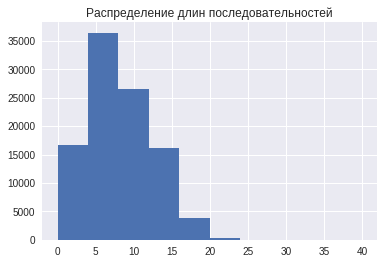

In [29]:
plt.hist([len(x) for x in train_seqs])
plt.title("Распределение длин последовательностей")
plt.show()

In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [0]:
# обрезаем последовательности в начале, добиваем нулями до 20 при необходимости в конце
# тут можно все поменять на свой вкус, конечно же
padded = pad_sequences(train_seqs, maxlen=20, dtype='int32', padding='post', truncating='pre', value=0.0)

In [32]:
padded.shape

(100000, 20)

#### Загружаем эмбеддинги

In [0]:
!pip install gensim

In [0]:
# from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors

glove_file = 'glove.twitter.27B.100d.txt'
tmp_file = "glove.twitter.27B.100d_word2vec.txt"

In [0]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove2word2vec(glove_file, tmp_file)

model = KeyedVectors.load_word2vec_format(tmp_file,binary=False)

#### Colab

In [0]:
# save model
# model.save_word2vec_format(os.path.join(PY_MOUNT_PATH,"glove.twitter.27B.100d_word2vec.txt"),binary=True)

In [0]:
model = KeyedVectors.load_word2vec_format(os.path.join(PY_MOUNT_PATH,tmp_file),binary=True)

In [37]:
embedding_dict = model.wv

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


```python
#Load GLOVE vectors
filepath_glove = 'glove.twitter.27B.100d.txt'
glove_vocab = []
glove_embd=[]
embedding_dict = {}
 
file = open(filepath_glove,'r',encoding='UTF-8')
for line in file.readlines():
    row = line.strip().split(' ')
    vocab_word = row[0]
    glove_vocab.append(vocab_word)
    embed_vector = [float(i) for i in row[1:]] # convert to list of float
    embedding_dict[vocab_word]=embed_vector
file.close()
```

In [38]:
len(embedding_dict.vectors)

1193515

In [39]:
len(tokenizer.word_index)

61896

Подготовим матрицу для инициализации матрицы эмбеддингов модели.

In [0]:
# prepare embedding matrix
num_words = vocab_size+1
embedding_matrix = np.zeros((num_words, 100))
for word, i in tokenizer.word_index.items():
    if word in embedding_dict:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_dict[word]


In [41]:
embedding_matrix.shape

(61897, 100)

In [42]:
embedding_matrix[3]

array([ 8.56510028e-02, -1.46650001e-02, -2.05310002e-01, -1.39280006e-01,
       -4.55309987e-01,  6.68799996e-01, -1.54479995e-01,  3.23080003e-01,
       -5.15609980e-01,  9.61709991e-02, -3.68320011e-02,  2.70319998e-01,
       -2.86220002e+00,  4.15719986e-01, -2.20410004e-01, -8.23530018e-01,
       -7.08909988e-01, -3.17570001e-01, -7.45949984e-01,  1.16050005e+00,
       -2.99370004e-04, -1.32759996e-02,  5.38439989e-01,  3.20030004e-01,
        3.90480012e-01, -2.24939990e+00, -6.92139983e-01, -3.22939992e-01,
        6.84270024e-01,  5.99430025e-01, -9.13709998e-02, -5.60699999e-01,
       -3.16850007e-01, -1.17080003e-01,  1.70760000e+00, -6.35550022e-01,
       -4.32870001e-01, -2.25350007e-01,  3.58990014e-01,  2.38169998e-01,
       -1.85169995e+00,  3.09390008e-01,  4.79319990e-01, -8.77409995e-01,
       -1.85839996e-01, -5.05999982e-01,  2.83790007e-02, -7.27909982e-01,
        8.47489983e-02, -7.08559990e-01,  3.58980000e-01, -2.68689990e-01,
        1.28570005e-01,  

**Теперь Tensorflow точно вступает в игру**

Изготовим теперь удобный **tf.data.Dataset**

Более подробно можно прочитать об этом [здесь](https://towardsdatascience.com/how-to-use-dataset-in-tensorflow-c758ef9e4428) и [здесь](https://www.tensorflow.org/performance/datasets_performance)

In [0]:
tf.reset_default_graph()

In [0]:
emb_size = 100
BATCH_SIZE = 200
learning_rate = 0.001
EPOCHS = 1

In [0]:
y_train = np.array(train.sentiment)
y_train = np.expand_dims(y_train, axis=1)

In [0]:
dataset = tf.data.Dataset.from_tensor_slices((padded, y_train)).shuffle(BATCH_SIZE).repeat().batch(BATCH_SIZE)

С помощью dataset API можно удобно делать итератор для имеющихся данных.

In [47]:
iterator = dataset.make_one_shot_iterator()
get_next = iterator.get_next()
print(get_next)
inputs, labels = get_next

(<tf.Tensor 'IteratorGetNext:0' shape=(?, 20) dtype=int32>, <tf.Tensor 'IteratorGetNext:1' shape=(?, 1) dtype=int64>)


**Модель**

Мы хотим сделать очень простую модель с однослойной LSTM ячейкой, которая будет пробегать по всей последовательности из слов длины 20. На каждом элементе последовательности LSTM выдает output. Мы хотим использовать output'ы для предсказания вероятности принадлежности последовательности к классу позитивных твиттов.

Матрицу эмбеддингов фиксируем, она не будет тренироваться в процессе обучения модели. 

In [0]:
embedding_mtx = tf.get_variable(name="embedding_mtx",
                                shape=embedding_matrix.shape,
                                initializer=tf.constant_initializer(embedding_matrix),
                                trainable=False)

Эта функция позволяет по индексам элементов входной последовательности (`inputs`) составить матрицу из соответствующих векторов слов из матрицы эмбеддингов (`embedding_mtx`).

In [0]:
inputs_embedded = tf.nn.embedding_lookup(params=embedding_mtx, ids=inputs)

Посмотрим на размерность полученной матрицы: [размер батча, длина последовательности, размерность эмбеддинга]

In [50]:
inputs_embedded

<tf.Tensor 'embedding_lookup/Identity:0' shape=(?, 20, 100) dtype=float32>

Однослойная LSTM сеть с размерностью выхода 100:

In [0]:
outputs, states = tf.nn.dynamic_rnn(cell=tf.nn.rnn_cell.LSTMCell(100), inputs=inputs_embedded, dtype=tf.float32)

outputs -- это выходы LSTM после каждого элемента последовательности.

In [0]:
outputs = tf.layers.flatten(outputs)

In [53]:
logits = tf.layers.dense(inputs=outputs, units=1)
logits

<tf.Tensor 'dense/BiasAdd:0' shape=(?, 1) dtype=float32>

In [54]:
probs = tf.nn.sigmoid(logits)
probs

<tf.Tensor 'Sigmoid:0' shape=(?, 1) dtype=float32>

In [0]:
loss = tf.nn.sigmoid_cross_entropy_with_logits(
    labels=tf.cast(labels, dtype=tf.float32),
    logits=logits,
    name='loss'
)
loss = tf.reduce_mean(loss)

In [56]:
loss

<tf.Tensor 'Mean:0' shape=() dtype=float32>

In [0]:
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [0]:
#sess.close()

In [58]:
!pip install tqdm

In [59]:
import tqdm
losses = []
num_epochs = 1
num_iter_per_epoch = 3000

sess = tf.Session(tpu_address)
# sess = tf.Session()
sess.run(tf.global_variables_initializer())
for i in range(num_epochs):
  print('Epoch ',i)
  aver_loss = 0.
  for j in tqdm.tqdm(range(num_iter_per_epoch)):
    loss_cur, _ = sess.run([loss, train_op])
    aver_loss += loss_cur
    if j % 1000 == 0:
      print('Loss: ', aver_loss / 1000.)
      aver_loss = 0.
      
    losses.append(loss_cur)

  0%|          | 1/3000 [00:00<07:58,  6.27it/s]

Epoch  0
Loss:  0.00069000244140625


 33%|███▎      | 1004/3000 [00:35<01:10, 28.49it/s]

Loss:  0.5062554538249969


 67%|██████▋   | 2006/3000 [01:10<00:35, 28.21it/s]

Loss:  0.46745321851968763


100%|██████████| 3000/3000 [01:45<00:00, 28.32it/s]


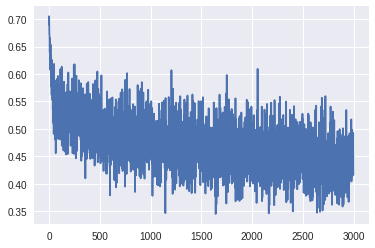

In [60]:
plt.plot(losses)

In [61]:
losses[-1]

0.41574195

**Измеряем точность**

In [0]:
test_seqs = tokenizer.texts_to_sequences(test.text)
padded_test = pad_sequences(test_seqs, maxlen=20, dtype='int32', padding='post', truncating='pre', value=0.0)

In [0]:
test_pred = sess.run(probs, feed_dict={inputs: padded_test})

In [64]:
from sklearn.metrics import f1_score, roc_auc_score
roc_auc_score(y_test, test_pred)

0.8818836530700939

In [69]:
print(precision_score(y_test, np.round(test_pred)),
      recall_score(y_test, np.round(test_pred)))

0.7868020304568528 0.8516483516483516


** Мы улучшили результат TF-IDF модели, но кажется, что можно куда лучше**

# Задание

Исследуйте нейронку и опишите свои наблюдения. Зафиксируйте количество итераций обучения и меняйте параметры сети. 
Можно выбрать для исследования **любые 3 ** из предложенных вопросов.

1.   Как размер батча влияет на roc_auc?
2.   Как размерность скрытого слоя LSTM влияет на roc_auc?
3.   Что изменится, если вместо всех outputs LSTM взять только последние выходы LSTM на последнем шаге. Улучшился или ухудшился при этом roc_auc?
4.   Что изменится, если взять char эмбеддинги заместо word? Провести эксперименты, добится roc_auc > 0.5. (Это может оказаться сложным, потому можно взять одну эту задачку вместо 3х)
5.   Что изменится, если взять несколько слоев LSTM?
6.   Что изменится, если взять bidirectional LSTM?
7.   Что если обучать эмбеддинги вместе с обучением модели и не использовать инициализацию предобученными эмбеддингами? Сколько потребуется итераций обучения, чтобы достичь результата с использованием предобученных эмбеддингов?

Опишите подробно что вы делали словами и что у вас вышло.
Код тоже нужно оставить доступным для обозрения.

Получилось ли у вас улучшить результат нейронки?

# Ваш отчет здесь


### 1. Bidirect LSTM

In [0]:
tf.reset_default_graph()

In [0]:
emb_size = 100
BATCH_SIZE = 200
learning_rate = 0.001
EPOCHS = 1

In [0]:
def setup_input():
    tf.reset_default_graph()
    y_train = np.array(train.sentiment)
    y_train = np.expand_dims(y_train, axis=1)

    dataset = tf.data.Dataset.from_tensor_slices((padded, y_train)).shuffle(BATCH_SIZE).repeat().batch(BATCH_SIZE)
    
    iterator = dataset.make_one_shot_iterator()
    get_next = iterator.get_next()
    inputs, labels = get_next
    
    embedding_mtx = tf.get_variable(name="embedding_mtx",
                                shape=embedding_matrix.shape,
                                initializer=tf.constant_initializer(embedding_matrix),
                                trainable=False)


    inputs_embedded = tf.nn.embedding_lookup(params=embedding_mtx, ids=inputs)
    return inputs_embedded, labels,inputs

In [0]:
inputs_embedded, labels,inputs = setup_input()

In [0]:
outputs, _ = tf.nn.bidirectional_dynamic_rnn(
    cell_fw=tf.nn.rnn_cell.LSTMCell(100),
    cell_bw=tf.nn.rnn_cell.LSTMCell(100),
    inputs=inputs_embedded, dtype=tf.float32)

outputs = tf.layers.flatten(tf.concat(outputs,-1))
logits = tf.layers.dense(inputs=outputs, units=1)
probs = tf.nn.sigmoid(logits)

In [0]:
loss = tf.nn.sigmoid_cross_entropy_with_logits(
    labels=tf.cast(labels, dtype=tf.float32),
    logits=logits,
    name='loss'
)
loss = tf.reduce_mean(loss)
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [76]:
import tqdm
losses = []
num_epochs = 1
num_iter_per_epoch = 3000
test_pred=None

with tf.Session(tpu_address) as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(num_epochs):
      print('Epoch ',i)
      aver_loss = 0.
      for j in tqdm.tqdm(range(num_iter_per_epoch)):
        loss_cur, _ = sess.run([loss, train_op])
        aver_loss += loss_cur
        if j % 1000 == 0:
          print('Loss: ', aver_loss / 1000.)
          aver_loss = 0.

        losses.append(loss_cur)
    test_seqs = tokenizer.texts_to_sequences(test.text)
    padded_test = pad_sequences(test_seqs, maxlen=20, dtype='int32', padding='post', truncating='pre', value=0.0)
    test_pred = sess.run(probs, feed_dict={inputs: padded_test})

  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch  0


  0%|          | 4/3000 [00:00<10:02,  4.97it/s]

Loss:  0.0006934852600097656


 34%|███▎      | 1006/3000 [00:37<01:14, 26.72it/s]

Loss:  0.5045834826827049


 67%|██████▋   | 2005/3000 [01:14<00:37, 26.30it/s]

Loss:  0.4617149746119976


100%|██████████| 3000/3000 [01:52<00:00, 26.74it/s]


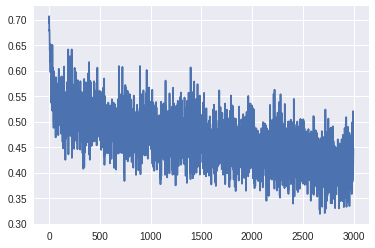

In [77]:
plt.plot(losses)

In [78]:
losses[-1]

0.44766328

In [79]:
from sklearn.metrics import f1_score, roc_auc_score
roc_auc_score(y_test, test_pred)

0.8703048364065313

In [80]:
print(precision_score(y_test, np.round(test_pred)),
      recall_score(y_test, np.round(test_pred)))

0.7727272727272727 0.8406593406593407


### 2. Выход последней ячейки

In [0]:
import tensorflow as tf

In [0]:
emb_size = 100
BATCH_SIZE = 200
learning_rate = 0.001
EPOCHS = 1

In [0]:
def setup_input():
    tf.reset_default_graph()
    y_train = np.array(train.sentiment)
    y_train = np.expand_dims(y_train, axis=1)

    dataset = tf.data.Dataset.from_tensor_slices((padded, y_train)).shuffle(BATCH_SIZE).repeat().batch(BATCH_SIZE)
    
    iterator = dataset.make_one_shot_iterator()
    get_next = iterator.get_next()
    inputs, labels = get_next
    
    embedding_mtx = tf.get_variable(name="embedding_mtx",
                                shape=embedding_matrix.shape,
                                initializer=tf.constant_initializer(embedding_matrix),
                                trainable=False)


    inputs_embedded = tf.nn.embedding_lookup(params=embedding_mtx, ids=inputs)
    return inputs_embedded, labels,inputs

In [0]:
inputs_embedded, labels,inputs = setup_input()

In [0]:
outputs, _ = tf.nn.dynamic_rnn(
    cell=tf.nn.rnn_cell.LSTMCell(100),
    inputs=inputs_embedded, dtype=tf.float32)

outputs = outputs[:,:,-1]

In [0]:
logits = tf.layers.dense(inputs=outputs, units=1)
probs = tf.nn.sigmoid(logits)

loss = tf.nn.sigmoid_cross_entropy_with_logits(
    labels=tf.cast(labels, dtype=tf.float32),
    logits=logits,
    name='loss'
)
loss = tf.reduce_mean(loss)
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [0]:
loss = tf.nn.sigmoid_cross_entropy_with_logits(
    labels=tf.cast(labels, dtype=tf.float32),
    logits=logits,
    name='loss'
)
loss = tf.reduce_mean(loss)
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [100]:
import tqdm
losses = []
num_epochs = 1
num_iter_per_epoch = 3000
test_pred=None

with tf.Session(tpu_address) as sess:
# with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(num_epochs):
      print('Epoch ',i)
      aver_loss = 0.
      for j in tqdm.tqdm(range(num_iter_per_epoch)):
        loss_cur, _ = sess.run([loss, train_op])
        aver_loss += loss_cur
        if j % 1000 == 0:
          print('Loss: ', aver_loss / 1000.)
          aver_loss = 0.

        losses.append(loss_cur)
    test_seqs = tokenizer.texts_to_sequences(test.text)
    padded_test = pad_sequences(test_seqs, maxlen=20, dtype='int32', padding='post', truncating='pre', value=0.0)
    test_pred = sess.run(probs, feed_dict={inputs: padded_test})

  0%|          | 1/3000 [00:00<08:28,  5.90it/s]

Epoch  0
Loss:  0.0006920710802078247


 34%|███▎      | 1006/3000 [00:35<01:09, 28.77it/s]

Loss:  0.5180339204967022


 67%|██████▋   | 2006/3000 [01:10<00:35, 28.05it/s]

Loss:  0.4709596933722496


100%|██████████| 3000/3000 [01:45<00:00, 27.90it/s]


In [101]:
losses[-1]

0.48317838

In [102]:
from sklearn.metrics import f1_score, roc_auc_score
roc_auc_score(y_test, test_pred)

0.8861985472154964

In [103]:
print(precision_score(y_test, np.round(test_pred)),
      recall_score(y_test, np.round(test_pred)))

0.7857142857142857 0.8461538461538461


### 3. Несколько слоев

In [0]:
import tensorflow as tf

emb_size = 100
BATCH_SIZE = 200
learning_rate = 0.001
EPOCHS = 1

def setup_input():
    tf.reset_default_graph()
    y_train = np.array(train.sentiment)
    y_train = np.expand_dims(y_train, axis=1)

    dataset = tf.data.Dataset.from_tensor_slices((padded, y_train)).shuffle(BATCH_SIZE).repeat().batch(BATCH_SIZE)
    
    iterator = dataset.make_one_shot_iterator()
    get_next = iterator.get_next()
    inputs, labels = get_next
    
    embedding_mtx = tf.get_variable(name="embedding_mtx",
                                shape=embedding_matrix.shape,
                                initializer=tf.constant_initializer(embedding_matrix),
                                trainable=False)


    inputs_embedded = tf.nn.embedding_lookup(params=embedding_mtx, ids=inputs)
    return inputs_embedded, labels,inputs

In [111]:
inputs_embedded, labels,inputs = setup_input()

num_units = [100, 80,60]
cells = [tf.nn.rnn_cell.BasicLSTMCell(num_units=n) for n in num_units]
stacked_rnn_cell = tf.nn.rnn_cell.MultiRNNCell(cells)

outputs, _ = tf.nn.dynamic_rnn(
    cell=stacked_rnn_cell,
    inputs=inputs_embedded, dtype=tf.float32)

outputs = tf.layers.flatten(outputs)

logits = tf.layers.dense(inputs=outputs, units=1)
probs = tf.nn.sigmoid(logits)

loss = tf.nn.sigmoid_cross_entropy_with_logits(
    labels=tf.cast(labels, dtype=tf.float32),
    logits=logits,
    name='loss'
)
loss = tf.reduce_mean(loss)
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

loss = tf.nn.sigmoid_cross_entropy_with_logits(
    labels=tf.cast(labels, dtype=tf.float32),
    logits=logits,
    name='loss'
)
loss = tf.reduce_mean(loss)
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').


In [0]:
import tqdm
losses = []
num_epochs = 1
num_iter_per_epoch = 3000
test_pred=None

In [113]:
with tf.Session(tpu_address) as sess:
# with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(num_epochs):
      print('Epoch ',i)
      aver_loss = 0.
      for j in tqdm.tqdm(range(num_iter_per_epoch)):
        loss_cur, _ = sess.run([loss, train_op])
        aver_loss += loss_cur
        if j % 1000 == 0:
          print('Loss: ', aver_loss / 1000.)
          aver_loss = 0.

        losses.append(loss_cur)
    test_seqs = tokenizer.texts_to_sequences(test.text)
    padded_test = pad_sequences(test_seqs, maxlen=20, dtype='int32', padding='post', truncating='pre', value=0.0)
    test_pred = sess.run(probs, feed_dict={inputs: padded_test})

losses[-1]

from sklearn.metrics import f1_score, roc_auc_score
roc_auc_score(y_test, test_pred)

  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch  0


  0%|          | 4/3000 [00:00<13:57,  3.58it/s]

Loss:  0.0006903998851776123


 34%|███▎      | 1006/3000 [00:40<01:18, 25.52it/s]

Loss:  0.5070007729828357


 67%|██████▋   | 2005/3000 [01:20<00:43, 23.03it/s]

Loss:  0.4689660693407059


100%|██████████| 3000/3000 [01:59<00:00, 25.04it/s]


0.8816353138387036

In [114]:
print(precision_score(y_test, np.round(test_pred)),
      recall_score(y_test, np.round(test_pred)))

0.7804878048780488 0.8791208791208791


In [115]:
losses[-1]

0.40200555

### Вывод:

| Модификация | Значение функции потерь | ROC-AUC | precision | recall |
| ------ | ----------- | ----------- | -----------| -----------|
|1. Baseline tf| 0.4157| 0.8819| 0.7868| 0.8516 |
|2. Bidirect LSTM| 0.4477| 0.8703| 0.7727| 0.8407 |
|3. Выход последней ячейки| 0.4832| 0.8862| 0.7857| 0.8462 |
|4. Несколько слоев| 0.4020| 0.8816| 0.7805| 0.8791 |

Лучшее значение ROC-AUC получено для модификации в которой используется выход с последней ячейки. Наименьшее значение функции потерь на тренировачной выборке получено для модели с несколькими слоями. Значение точности лучше у базовой модели, а полноты у модели с несколькими слоями